In [50]:
# using Pkg/
# Pkg.activate(".")

In [51]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools

In [52]:
#mu - gravitational parameter (m3/s2)
mu = 3.986e14

3.986e14

In [53]:
#radius of Earth (m)
r_e = 6.371e6

6.371e6

In [54]:
#sma from ppt
a = 6.85635e6

6.85635e6

In [55]:
#constant mean motion of target n = sqrt(mu/a^3)
#units: rad/s
n = sqrt(mu/a^3)

0.0011120624547982091

In [56]:
#number of states
nx = 6

#number of control inputs
nu = 3

3

In [57]:
#this is a whole orbit for dt=60
N = 94

#this is a whole orbit for dt=5650

#N = 5650

94

In [58]:
#target orbit period in seconds
T = 2*pi*sqrt((a^3)/(mu))

5650.029168838104

In [59]:
#timestep 
dt = 60

#dt = 1

60

In [60]:
thist = LinRange(1, N*dt, N)

94-element LinRange{Float64, Int64}:
 1.0, 61.6344, 122.269, 182.903, 243.538, …, 5458.1, 5518.73, 5579.37, 5640.0

In [61]:
x0_target = zeros(nx) 

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [62]:
#using the true data from the ppt
#this is in eci frame
# x0_chaser = [-0.2913181949406862,
#              -259.0113696278884,
#              1986.134383662354,
#              -2.2156282462577286,
#              4.171718001089175e-5,
#              -0.0003198930062353611]

In [63]:
#this is in RTN frame

x0_chaser = [ -0.2913181949406862
              2002.9519913273894
              2.7017514072632172e-14
              0.002412819262479271
              -1.5962127995240716e-12
              3.511794450825904e-14]

6-element Vector{Float64}:
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [64]:
A = zeros(nx, nx)
A[1:3, 4:6] = I(3)
A[4, 1] = 3*n^2
A[6, 3] = -n^2
A[4, 5] = 2*n
A[5, 4] = -2*n

-0.0022241249095964182

In [65]:
#mass of the satellite (kg) from data
m = 5.22

5.22

In [66]:
B = [zeros(3,3); I(3)]

6×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [67]:
#continous dynamics
function spacecraft_dynamics(x,u)

    xdot = A*x + B*u

    return xdot

end

spacecraft_dynamics (generic function with 1 method)

In [68]:
#discretize the dynamics model 
H = exp(dt*[A B; zeros(nu, nx+nu)])

9×9 Matrix{Float64}:
  1.00668      0.0   0.0         …  1799.33       80.0507      0.0
 -0.000296992  1.0   0.0             -80.0507   1797.33        0.0
  0.0          0.0   0.997775          0.0         0.0      1799.33
  0.000222438  0.0   0.0              59.9555      4.00194     0.0
 -1.48474e-5   0.0   0.0              -4.00194    59.822       0.0
  0.0          0.0  -7.41459e-5  …     0.0         0.0        59.9555
  0.0          0.0   0.0               1.0         0.0         0.0
  0.0          0.0   0.0               0.0         1.0         0.0
  0.0          0.0   0.0               0.0         0.0         1.0

In [69]:
#Discrete Dynamics Matrices
Ad  = H[1:nx, 1:nx]
Bd = H[1:nx, (nx+1):end]

6×3 Matrix{Float64}:
 1799.33       80.0507      0.0
  -80.0507   1797.33        0.0
    0.0         0.0      1799.33
   59.9555      4.00194     0.0
   -4.00194    59.822       0.0
    0.0         0.0        59.9555

In [70]:
Ad 

6×6 Matrix{Float64}:
  1.00668      0.0   0.0         59.9555     4.00194    0.0
 -0.000296992  1.0   0.0         -4.00194   59.822      0.0
  0.0          0.0   0.997775     0.0        0.0       59.9555
  0.000222438  0.0   0.0          0.997775   0.133348   0.0
 -1.48474e-5   0.0   0.0         -0.133348   0.991099   0.0
  0.0          0.0  -7.41459e-5   0.0        0.0        0.997775

In [71]:
eigen(Ad) 

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
6-element Vector{ComplexF64}:
 0.9977747965190653 - 0.06667424863720976im
 0.9977747965190653 + 0.06667424863720976im
 0.9977747965190695 - 0.06667424863720961im
 0.9977747965190695 + 0.06667424863720961im
 0.9999999999999911 + 0.0im
 0.9999999999999982 + 0.0im
vectors:
6×6 Matrix{ComplexF64}:
  4.35763e-15-0.442187im     …  -7.09935e-14+0.0im  0.0+0.0im
    -0.884373-0.0im                     -1.0+0.0im  1.0+0.0im
   -0.0270309+0.147047im        -4.59913e-31+0.0im  0.0+0.0im
 -0.000491739-3.23905e-18im      9.98568e-30+0.0im  0.0+0.0im
 -1.63172e-17+0.000983478im      1.18424e-16+0.0im  0.0+0.0im
  0.000163526+3.006e-5im     …           0.0+0.0im  0.0+0.0im

In [72]:
#discrete dynamics
function spacecraft_dynamics_discrete(x,u)

    xnext = Ad*x + Bd*u

    return xnext

end

spacecraft_dynamics_discrete (generic function with 1 method)

In [73]:
x_initial = x0_chaser

6-element Vector{Float64}:
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [74]:
x_goal = x0_target

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [75]:
Q = 1.0*Matrix(I, nx, nx)
R = 1e10*Matrix(I, nu, nu)

3×3 Matrix{Float64}:
 1.0e9  0.0    0.0
 0.0    1.0e9  0.0
 0.0    0.0    1.0e9

In [76]:
using ControlSystems

In [77]:
#optimal gain matrix
K = dlqr(Ad, Bd, Q, R) 

3×6 Matrix{Float64}:
  2.75305e-5  -7.08656e-6  -0.0         …   0.000280866  -0.0
  7.13423e-6   2.40096e-5  -0.0             0.00694085   -0.0
 -0.0         -0.0          2.38228e-5     -0.0           0.00693595

In [78]:
function controller(x)

    u = -K*x

end

controller (generic function with 1 method)

In [79]:
#running the sim for this amount of iterations
iterations = 50

50

In [80]:
xhist = zeros(nx, iterations)
uhist = zeros(nu, iterations-1)

3×49 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [81]:
xhist[:,1] = x_initial

6-element Vector{Float64}:
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [82]:
for k=1:(iterations-1)

    uhist[:,k] = controller(xhist[:,k])

    xhist[:,k+1] = spacecraft_dynamics_discrete(xhist[:,k],uhist[:,k])

end

In [83]:
xhist

6×50 Matrix{Float64}:
   -0.291318       21.5245       …  -0.00320096   -0.00193856
 2002.95         1915.38             0.0108947     0.00368878
    2.70175e-14     1.69304e-12     -9.02848e-17  -5.44739e-17
    0.00241282      0.660334         3.03143e-5    1.27428e-5
   -1.59621e-12    -2.93377         -0.000140819  -9.89884e-5
    3.51179e-14     2.03955e-14  …   6.68554e-19   5.24698e-19

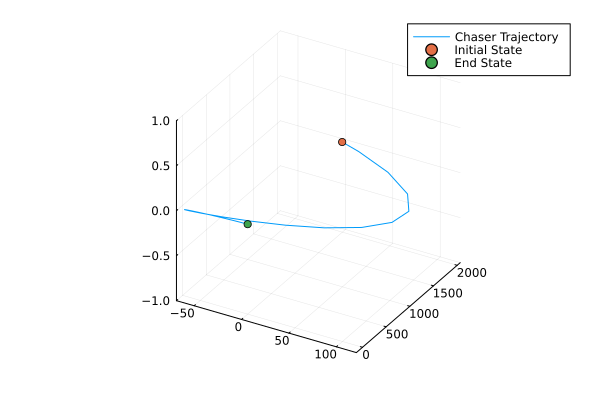

In [84]:
plot(xhist[1,:], xhist[2,:], xhist[3,:], label = "Chaser Trajectory", zlims=(-1,1))

scatter!([xhist[1,1]], [xhist[2,1]], [xhist[3,1]], label = "Initial State")
scatter!([xhist[1,end]], [xhist[2,end]], [xhist[3,end]], label = "End State")

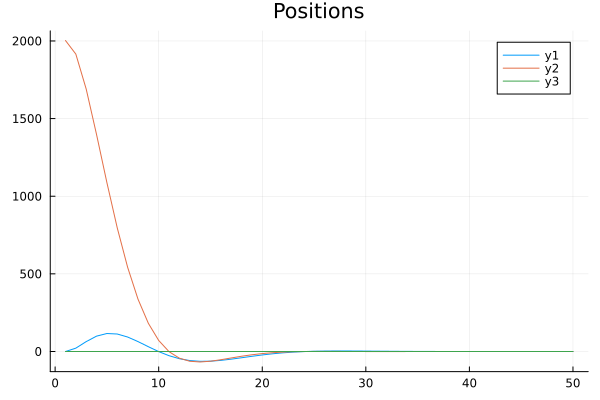

In [86]:
plot(xhist[1,:], title= "Positions")
plot!(xhist[2,:])
plot!(xhist[3,:])

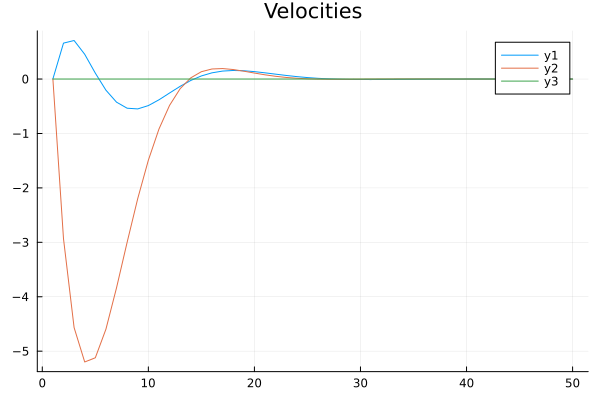

In [87]:
plot(xhist[4,:], title= "Velocities")
plot!(xhist[5,:])
plot!(xhist[6,:])

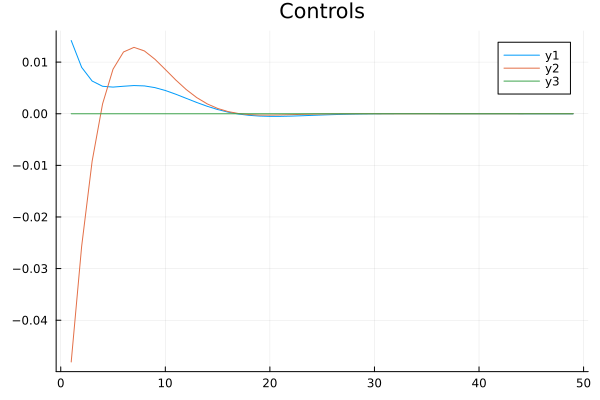

In [88]:
plot(uhist[1,:], title= "Controls")
plot!(uhist[2,:])
plot!(uhist[3,:])

In [89]:
#works well with a timestep dt =1 

#oscillates a lot when close to goal with timestep dt=60

In [90]:
#this is because the chaser can reach the target in less than 60 seconds. and since there is no notion of low thrust, it just overshoots by alot 
#once it reaches the goal

In [91]:
x_no_control = zeros(6, iterations)

6×50 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [92]:
x_no_control[:,1] = x_initial 

6-element Vector{Float64}:
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [93]:
#simulating no control 

for i = 1:iterations-1

    x_no_control[:,i+1] = Ad*x_no_control[:,i]

end

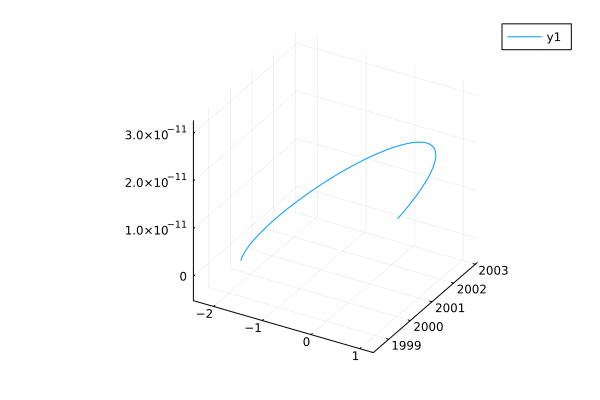

In [94]:
plot(x_no_control[1,:], x_no_control[2,:], x_no_control[3,:]) 

#plot!(xhist[1,:], xhist[2,:], xhist[3,:])